In [ ]:
import jax
import jax.numpy as jnp
import discovery as ds
import eryn
import glob

from discoverysamplers.eryn_interface import DiscoveryErynBridge

In [8]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/NanoGrav_15yr/*-[JB]*.feather'))]

print(f"Loaded {len(allpsrs)} pulsars from feather files.")

psrs = allpsrs[:3]

print("Building likelihood for 3 pulsars...")

m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                        ds.makenoise_measurement(psr, psr.noisedict),
                                        ds.makegp_ecorr(psr, psr.noisedict),
                                        ds.makegp_timing(psr, svd=True),
                                        ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])
                for psr in psrs])
print("...done.")

Loaded 67 pulsars from feather files.
Building likelihood for 3 pulsars...
...done.


In [11]:
m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A']

In [12]:
# Make Latex labels for parameters
latex_labels = {}
for param in m.logL.params:
    if 'log10_A' in param:
        pulsar_name = param.split('_rednoise_')[0]
        latex_labels[param] = r"$\log_{10} A_{" + pulsar_name + r"}$"
    elif 'gamma' in param:
        pulsar_name = param.split('_rednoise_')[0]
        latex_labels[param] = r"$\gamma_{" + pulsar_name + r"}$"
    else:
        latex_labels[param] = param
print(latex_labels)

{'B1855+09_rednoise_gamma': '$\\gamma_{B1855+09}$', 'B1855+09_rednoise_log10_A': '$\\log_{10} A_{B1855+09}$', 'B1937+21_rednoise_gamma': '$\\gamma_{B1937+21}$', 'B1937+21_rednoise_log10_A': '$\\log_{10} A_{B1937+21}$', 'B1953+29_rednoise_gamma': '$\\gamma_{B1953+29}$', 'B1953+29_rednoise_log10_A': '$\\log_{10} A_{B1953+29}$'}


In [13]:
p0 = ds.sample_uniform(m.logL.params, n=1)
print(p0)
m.logL(p0)

{'B1855+09_rednoise_gamma': 6.04065126614811, 'B1855+09_rednoise_log10_A': -17.839811498483122, 'B1937+21_rednoise_gamma': 4.757571214863929, 'B1937+21_rednoise_log10_A': -12.087582518869478, 'B1953+29_rednoise_gamma': 2.41934837818524, 'B1953+29_rednoise_log10_A': -11.969873549447676}


Array(473638.35625857, dtype=float64)

In [14]:

test_priors = {
    'B1855+09_rednoise_gamma': {'dist': 'uniform', 'min': 0, 'max': 7},
    'B1855+09_rednoise_log10_A': {'dist': 'uniform', 'min': -20, 'max': -11},
    'B1937+21_rednoise_gamma': {'dist': 'uniform', 'min': 0, 'max': 7},
    'B1937+21_rednoise_log10_A': {'dist': 'fixed', 'value': -13.5},
    'B1953+29_rednoise_gamma': {'dist': 'fixed', 'value': 3},
    'B1953+29_rednoise_log10_A': {'dist': 'uniform', 'min': -20, 'max': -11},
}

In [15]:
bridge = DiscoveryErynBridge(m, priors=test_priors, latex_labels=latex_labels)

In [16]:
print(bridge.eryn_prior_dict)

{0: <eryn.prior.UniformDistribution object at 0x3da2032b0>, 1: <eryn.prior.UniformDistribution object at 0x3da203340>, 2: <eryn.prior.UniformDistribution object at 0x3da203220>, 3: <eryn.prior.UniformDistribution object at 0x3da203430>}


In [8]:
print(bridge.sampled_prior_dict)
print(bridge.fixed_param_dict)
print(bridge.eryn_mapping)

{'B1855+09_rednoise_gamma': <eryn.prior.UniformDistribution object at 0x3ab5bfdc0>, 'B1855+09_rednoise_log10_A': <eryn.prior.UniformDistribution object at 0x3ab5bfdf0>, 'B1937+21_rednoise_gamma': <eryn.prior.UniformDistribution object at 0x3ab5bfe20>, 'B1953+29_rednoise_log10_A': <eryn.prior.UniformDistribution object at 0x3ab5bfe50>}
{'B1937+21_rednoise_log10_A': -13.5, 'B1953+29_rednoise_gamma': 3}
{'B1855+09_rednoise_gamma': 0, 'B1855+09_rednoise_log10_A': 1, 'B1937+21_rednoise_gamma': 2, 'B1953+29_rednoise_log10_A': 3}


In [9]:
ntemps = 3
tempering_kwargs=dict(ntemps=ntemps)

bridge.create_sampler(nwalkers=13, tempering_kwargs=tempering_kwargs)
bridge.sampler.backend.shape["model_0"]


(3, 13, 1, 4)

In [10]:
sampler = bridge.run_sampler(nsteps=500, burn=300, progress=True)

100%|██████████| 500/500 [00:08<00:00, 59.38it/s]


In [11]:
# Get the chain samples from the dict
samples = bridge.return_sampled_samples()
print(samples["names"])
print(samples["chain"].shape) 

['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A', 'B1937+21_rednoise_gamma', 'B1953+29_rednoise_log10_A']
(500, 3, 13, 1, 4)


/var/folders/6y/nrh4dqv10xxc55k_v95rl4l00000gn/T/ipykernel_58822/2166721642.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


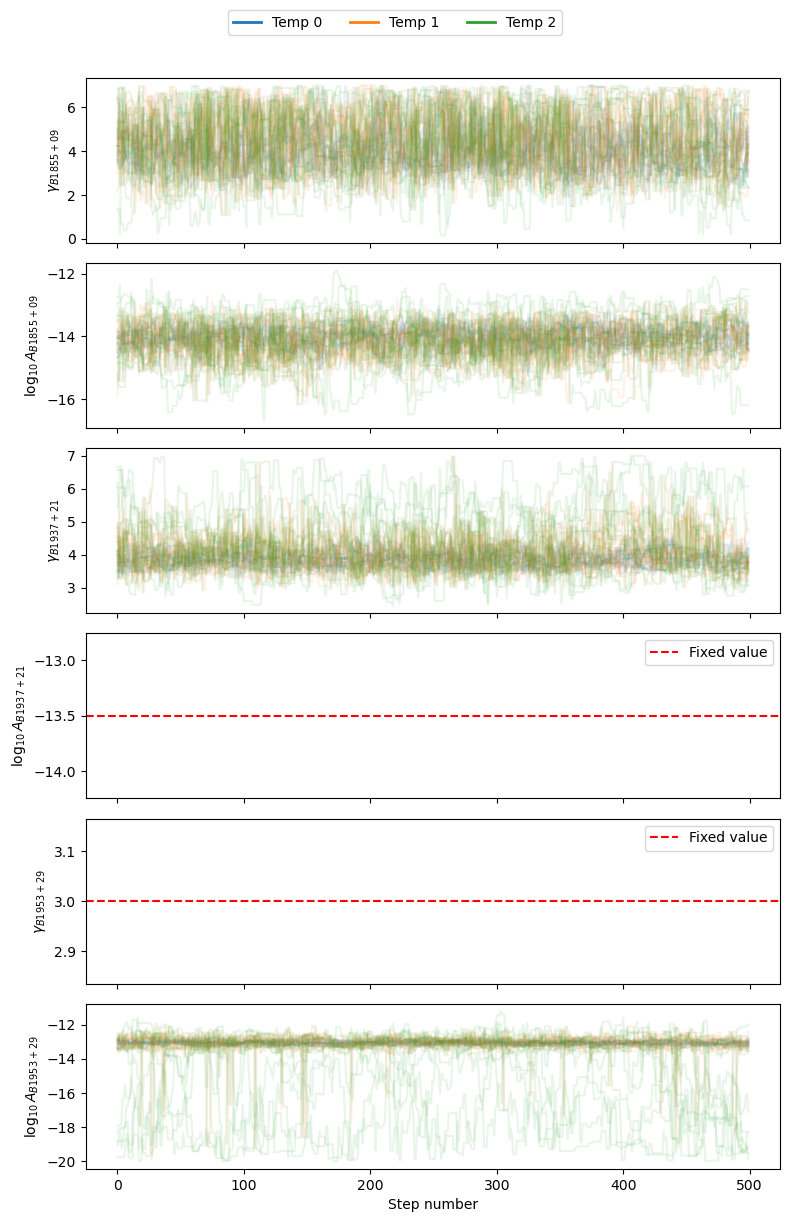

In [12]:
fig = bridge.plot_trace(plot_fixed=True)
fig.show()

/var/folders/6y/nrh4dqv10xxc55k_v95rl4l00000gn/T/ipykernel_58822/3008604745.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


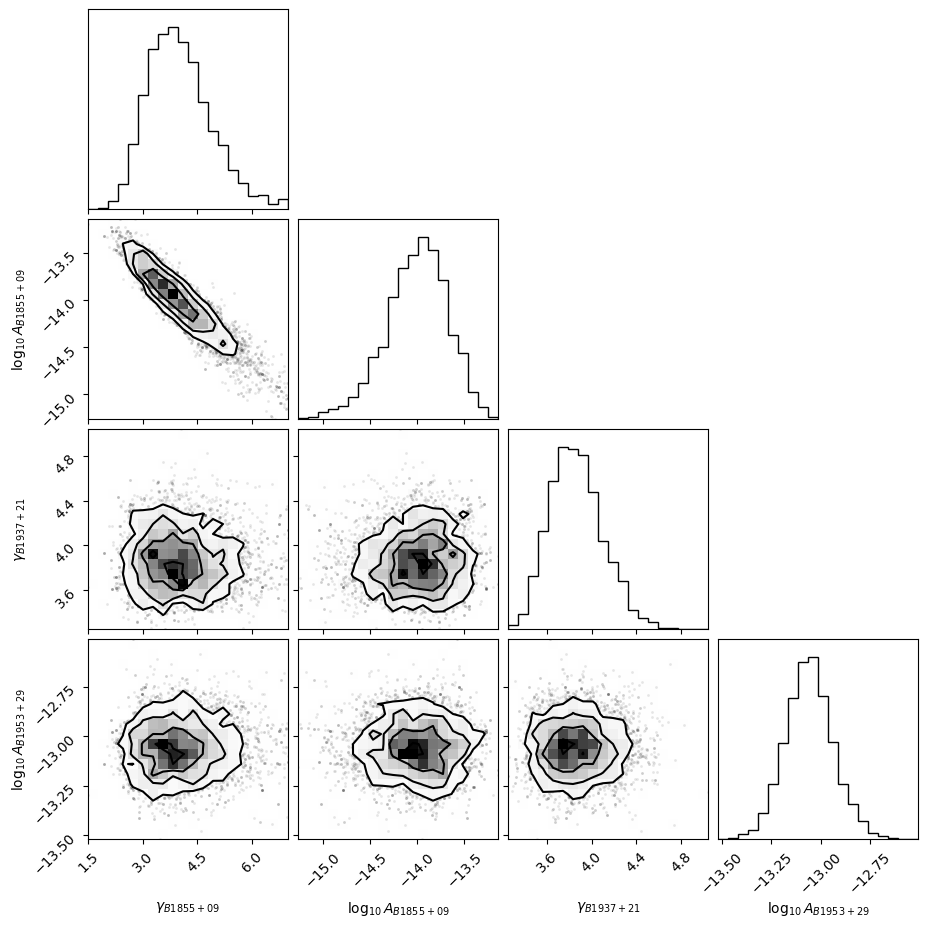

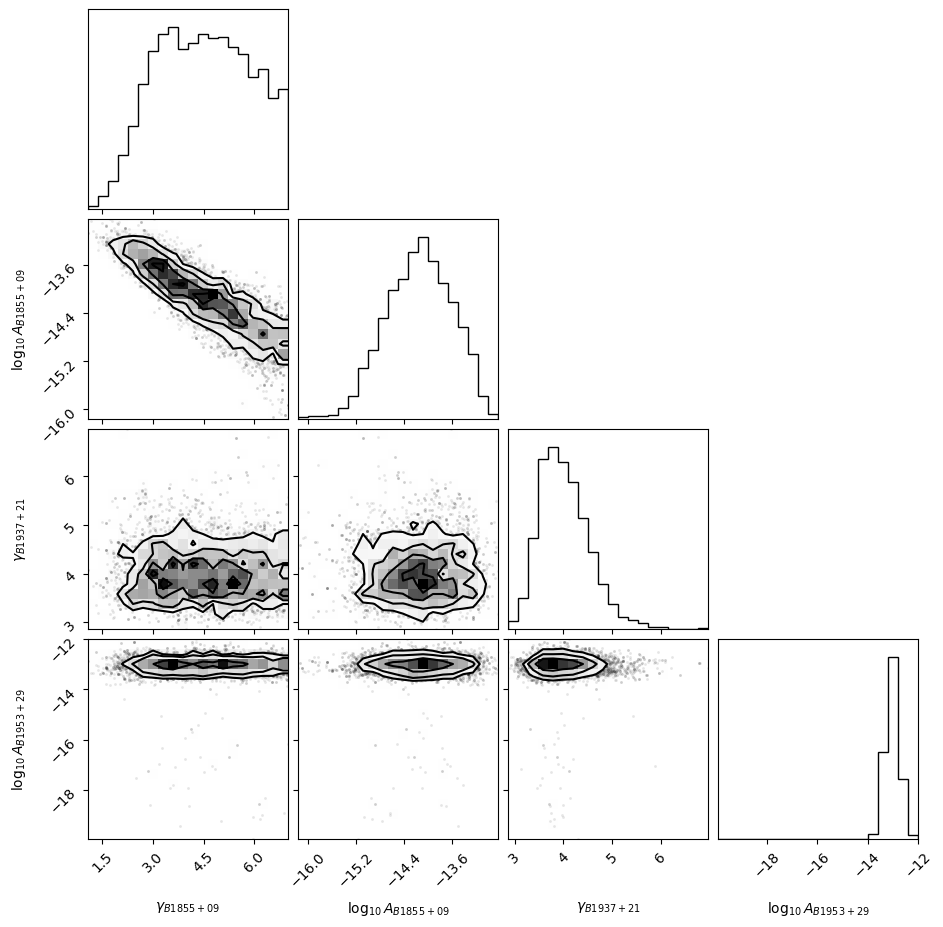

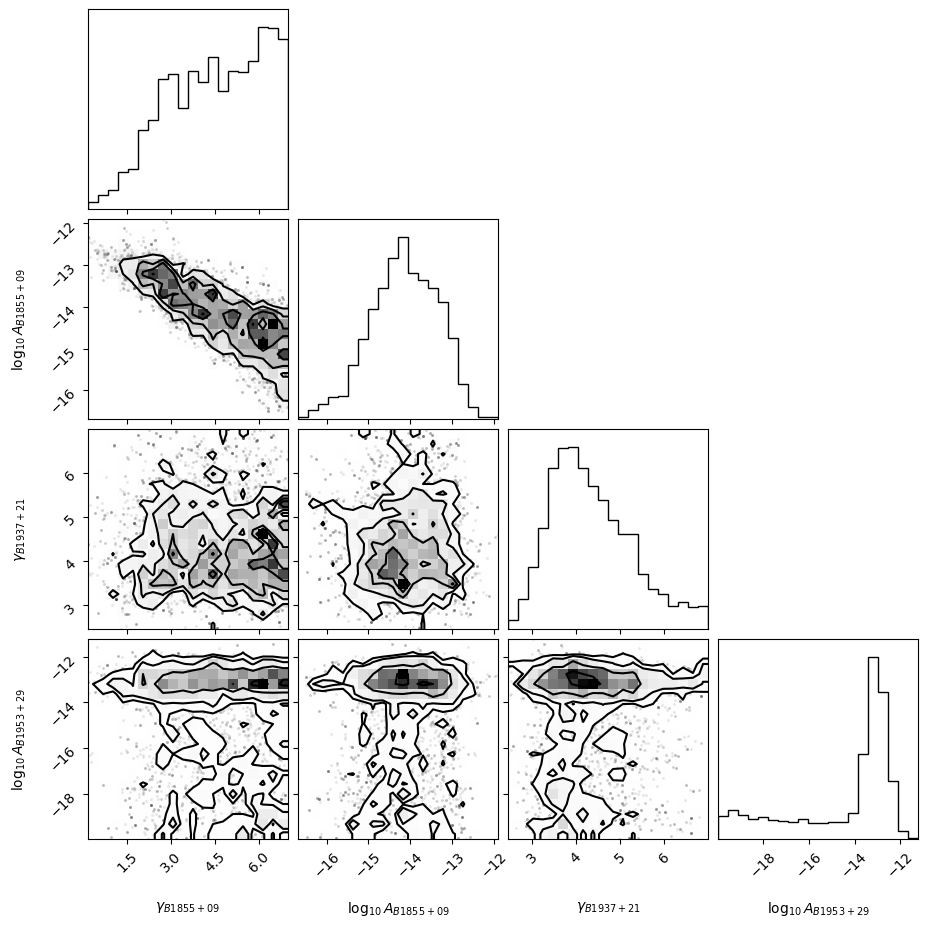

In [13]:
fig2 = bridge.plot_corner()
for fig in fig2:
    fig.show()